In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, kendalltau
import numpy as np

# Data Analysis

### Awards Player

In [40]:
awards_players_dataSet = pd.read_csv('../Other/basketballPlayoffs/awards_players.csv')
#print(awards_players_dataSet.info())
columns_to_remove = ['lgID']
awards_players_new = awards_players_dataSet.drop(columns=columns_to_remove)

awards_players_new = awards_players_new[(awards_players_new['award'] != 'Kim Perrot Sportsmanship Award') & (awards_players_new['award'] != 'Sixth Woman of the Year') ]

awards_players_new.to_csv('newDataset/awards_players_cleaned.csv', index=False)

### Coaches

In [41]:
coaches_dataSet = pd.read_csv('../Other/basketballPlayoffs/coaches.csv')
#print(coaches_dataSet.info())

#Check if stint could be removed
columns_to_remove = ['lgID']
coaches_new = coaches_dataSet.drop(columns=columns_to_remove)

coaches_new.to_csv('newDataset/coaches_cleaned.csv', index=False)

### Players

In [42]:
players_dataSet = pd.read_csv('../Other/basketballPlayoffs/players.csv')
#print(players_dataSet.info())

#Maybe everything is usless
columns_to_remove = ['pos','firstseason', 'lastseason', 'college', 'collegeOther']
players_dataSet_new = players_dataSet.drop(columns=columns_to_remove)

#rename attribute bioID
players_dataSet_new = players_dataSet_new.rename(columns={'bioID' : 'playerID'})

players_dataSet_new.to_csv('newDataset/players_cleaned.csv', index=False)

### Players Teams

In [43]:
players_teams_dataSet = pd.read_csv('../Other/basketballPlayoffs/players_teams.csv')
#print(players_teams_dataSet.info())

#Check if something else could be removed
columns_to_remove = ['lgID', 'turnovers']
players_teams_new = players_teams_dataSet.drop(columns=columns_to_remove)

players_teams_new.to_csv('newDataset/players_teams_cleaned.csv', index=False)

### Series Post

In [44]:
series_post_dataSet = pd.read_csv('../Other/basketballPlayoffs/series_post.csv')
#print(series_post_dataSet.info())

#Check if something else could be removed
columns_to_remove = ['lgIDWinner', 'lgIDLoser']
series_post_new = series_post_dataSet.drop(columns=columns_to_remove)

series_post_new.to_csv('newDataset/series_post_cleaned.csv', index=False)

### Teams

In [45]:
teams_dataSet = pd.read_csv('../Other/basketballPlayoffs/teams.csv')
#print(teams_dataSet.info()) 
columns_to_remove = ['lgID','divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB', 'homeW','homeL', 'awayW', 'awayL', 'confW','confL', 'min', 'attend', 'arena'] 
teams_new = teams_dataSet.drop(columns=columns_to_remove)

In [46]:
# two subset: east and west
teams_EA = teams_new[teams_new['confID'] == 'EA']
teams_WE = teams_new[teams_new['confID'] == 'WE']

# Salva i due dataset filtrati in file CSV separati
teams_EA.to_csv('newDataset/teams_EA_cleaned.csv', index=False)
teams_WE.to_csv('newDataset/teams_WE_cleaned.csv', index=False)

In [47]:
teams_ea_df = pd.read_csv('newDataset/teams_EA_cleaned.csv')
teams_we_df = pd.read_csv('newDataset/teams_WE_cleaned.csv')
players_teams_df = pd.read_csv('newDataset/players_teams_cleaned.csv')
players_cleaned_df = pd.read_csv('newDataset/players_cleaned.csv')
award_df = pd.read_csv('newDataset/awards_players_cleaned.csv')
coaches_df = pd.read_csv('newDataset/coaches_cleaned.csv')

merged_df_ea = pd.merge(teams_ea_df, players_teams_df, on=['year', 'tmID'], how='left')
merged_df_ea = pd.merge(merged_df_ea, players_cleaned_df, on=['playerID'], how='left')
merged_df_ea = pd.merge(merged_df_ea, award_df, on=['playerID', 'year'], how='left')
merged_df_ea = pd.merge(merged_df_ea, coaches_df, on=['year', 'tmID'], how='left')

merged_df_we = pd.merge(teams_we_df, players_teams_df, on=['year', 'tmID'], how='left')
merged_df_we = pd.merge(merged_df_we, players_cleaned_df, on=['playerID'], how='left')
merged_df_we = pd.merge(merged_df_we, award_df, on=['playerID', 'year'], how='left')
merged_df_we = pd.merge(merged_df_we, coaches_df, on=['year', 'tmID'], how='left')

merged_df_ea.to_csv('newDataset/teams_EA_cleaned.csv', index=False)
merged_df_we.to_csv('newDataset/teams_WE_cleaned.csv', index=False)


In [48]:
#add the column winrate
df_EA = pd.read_csv('newDataset/teams_EA_cleaned.csv')
df_WE = pd.read_csv('newDataset/teams_WE_cleaned.csv')

df_EA['winrate'] =  df_EA['won_x'] / df_EA['GP_x'] * 100
df_EA.to_csv('newDataset/teams_EA_cleaned.csv', index=False)

df_WE['winrate'] =  df_WE['won_x'] / df_WE['GP_x'] * 100
df_WE.to_csv('newDataset/teams_WE_cleaned.csv', index=False)

remove = ['won_x', 'lost_x']
df_EA = df_EA.drop(columns=remove)
df_EA.to_csv('newDataset/teams_EA_cleaned.csv', index=False)

df_WE = df_WE.drop(columns=remove)
df_WE.to_csv('newDataset/teams_WE_cleaned.csv', index=False)

In [49]:
# update mismatch
def update_team_data(df_teams_path, df_players, stat_column, team_column, output_path):
    df_teams = pd.read_csv(df_teams_path)
    
    # sum for each 
    sum_stats = df_players.groupby(['tmID', 'year'])[stat_column].sum().reset_index()
    sum_stats.rename(columns={stat_column: f'sum_{stat_column}Player'}, inplace=True)
    df_compare = pd.merge(df_teams, sum_stats, on=['tmID', 'year'], how='left')
    
    # mismatch and update values
    df_compare[f'diff_{stat_column}'] = df_compare[team_column] - df_compare[f'sum_{stat_column}Player']
    df_compare.loc[df_compare[f'diff_{stat_column}'] != 0, team_column] = df_compare[f'sum_{stat_column}Player']
    # remove temporary columns and save
    df_teams_updated = df_compare.drop(columns=[f'sum_{stat_column}Player', f'diff_{stat_column}'])
    df_teams_updated.to_csv(output_path, index=False)

df_players = pd.read_csv('newDataset/players_teams_cleaned.csv')

# EAST - update
update_team_data('newDataset/teams_EA_cleaned.csv', df_players, 'fgMade', 'o_fgm', 'newDataset/teams_EA_cleaned.csv')
update_team_data('newDataset/teams_EA_cleaned.csv', df_players, 'ftMade', 'o_ftm', 'newDataset/teams_EA_cleaned.csv')
update_team_data('newDataset/teams_EA_cleaned.csv', df_players, 'threeMade', 'o_3pm', 'newDataset/teams_EA_cleaned.csv')

# WEST - update
update_team_data('newDataset/teams_WE_cleaned.csv', df_players, 'fgMade', 'o_fgm', 'newDataset/teams_WE_cleaned.csv')
update_team_data('newDataset/teams_WE_cleaned.csv', df_players, 'ftMade', 'o_ftm', 'newDataset/teams_WE_cleaned.csv')
update_team_data('newDataset/teams_WE_cleaned.csv', df_players, 'threeMade', 'o_3pm', 'newDataset/teams_WE_cleaned.csv')

### Teams Posts

In [50]:
# Nothing to do for now
teams_post_dataSet = pd.read_csv('../Other/basketballPlayoffs/teams_post.csv')
columns_to_remove = [] 
teams_post_new = teams_post_dataSet.drop(columns=columns_to_remove)
teams_post_new.to_csv('newDataset/teams_post.csv', index=False)

## Correlations


Results for each award:
                                    award  Rank_1_4_Percentage
0                    Most Improved Player            58.941606
1                      Rookie of the Year            52.436195
2                    WNBA All-Decade Team            66.414141
3            Defensive Player of the Year            70.611702
4  WNBA All Decade Team Honorable Mention            66.666667
5      All-Star Game Most Valuable Player            76.076555
6        WNBA Finals Most Valuable Player            63.395225
7                    Most Valuable Player            73.698264
8                Kim Perrot Sportsmanship            80.000000
9                       Coach of the Year            75.000000


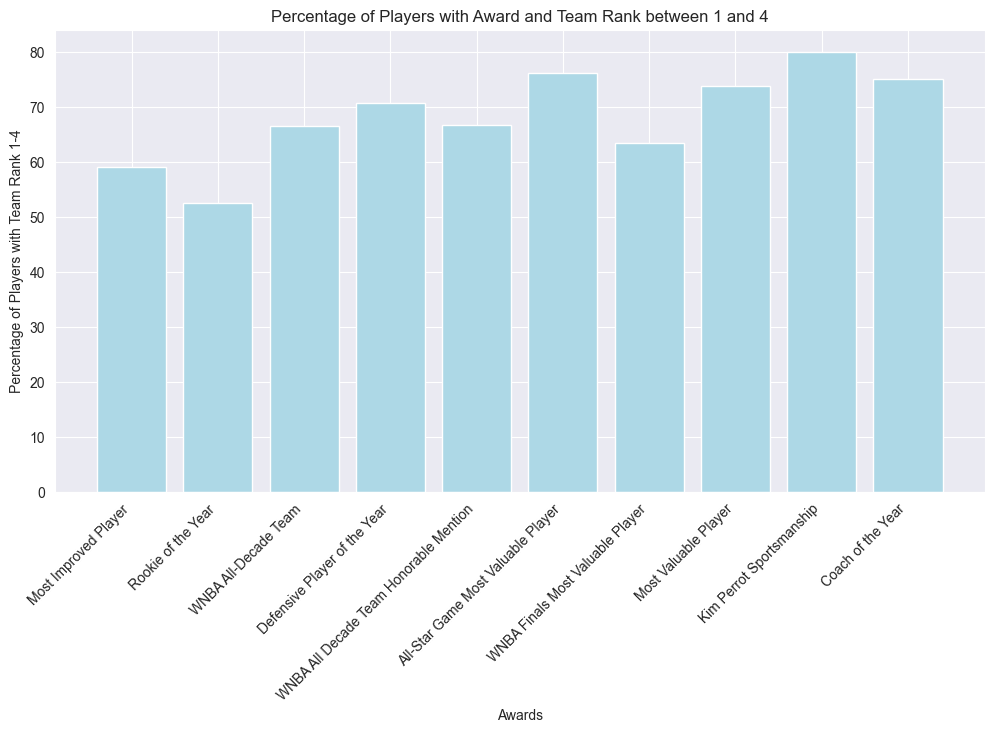

In [51]:
awards_players_df = pd.read_csv('newDataset/awards_players_cleaned.csv')
players_team_df = pd.read_csv('newDataset/players_teams_cleaned.csv')
teams_df = pd.read_csv('../Other/basketballPlayoffs/teams.csv')

merged_teams = pd.merge(players_team_df, teams_df, on='tmID', how='inner')
final_df = pd.merge(merged_teams, awards_players_df, on=['playerID'], how='inner')


awards_array = final_df['award'].unique()
results = []

for award in awards_array:
    award_df = final_df[final_df['award'] == award]

    rank_1_4_count = award_df[(award_df['rank'] >= 1) & (award_df['rank'] <= 4)].shape[0]
    total_count = award_df.shape[0]

    if total_count > 0:
        rank_1_4_percentage = (rank_1_4_count / total_count) * 100
    else:
        rank_1_4_percentage = 0

    results.append({'award': award, 'Rank_1_4_Percentage': rank_1_4_percentage})

results_df = pd.DataFrame(results)

print("\nResults for each award:")
print(results_df)

# 9. Visualizzazione della percentuale in un grafico a barre
plt.figure(figsize=(12, 6))
plt.bar(results_df['award'], results_df['Rank_1_4_Percentage'], color='lightblue')
plt.title('Percentage of Players with Award and Team Rank between 1 and 4')
plt.xlabel('Awards')
plt.ylabel('Percentage of Players with Team Rank 1-4')
plt.xticks(rotation=45, ha='right')
plt.show()